# 02 — Feature Engineering

This notebook transforms the raw features into improved predictors for ML models.

In [3]:
#mount Google Drive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [21]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.cluster import KMeans

sns.set()

df = pd.read_csv("/content/drive/MyDrive/CAS/VeloCheckZH/data/processed/data_for_model.csv")
#df = pd.read_csv("../data/processed/data_for_model.csv")
df.head()


,Standort_ID,Datum,Koord_Ost,Koord_Nord,Velo,year,day_of_year,Niederschlag,Temperatur Durchschnitt,weekday,weekend,is_holiday
0,60,2022-01-01,2682731,1247708,134.0,2022,1,0.0,2.6,5,True,True
1,732,2022-01-01,2681319,1248665,447.0,2022,1,0.0,2.6,5,True,True
2,1037,2022-01-01,2681339,1248647,1141.0,2022,1,0.0,2.6,5,True,True
3,2977,2022-01-01,2682681,1250570,259.0,2022,1,0.0,2.6,5,True,True
4,2978,2022-01-01,2683406,1251617,97.0,2022,1,0.0,2.6,5,True,True


# Temporal Features

In [36]:
##Extract richer date/time features (seasonality, periodicity)
# Make sure Datum is a proper datetime column
df["Datum"] = pd.to_datetime(df["Datum"])
# Day features
df["month"] = df["Datum"].dt.month
df["week"] = df["Datum"].dt.isocalendar().week.astype(int)
df["quarter"] = df["Datum"].dt.quarter

# Cyclic encoding for day_of_year (recommended!)
df["year_length"] = df["Datum"].dt.is_leap_year.map({True: 366, False: 365})
df["sin_day"] = np.sin(2 * np.pi * df["day_of_year"] / df["year_length"])
df["cos_day"] = np.cos(2 * np.pi * df["day_of_year"] / df["year_length"])

df["weekday"] = df["weekday"].astype('category')
df['weekday'] = df['weekday'].cat.rename_categories({
    0: 'Montag',
    1: 'Dienstag',
    2: 'Mittwoch',
    3: 'Donnerstag',
    4: 'Freitag',
    5: 'Samstag',
    6: 'Sonntag'
})
df.tail()



,Standort_ID,Datum,Koord_Ost,Koord_Nord,Velo,year,day_of_year,Niederschlag,Temperatur Durchschnitt,weekday,weekend,is_holiday,month,week,quarter,year_length,sin_day,cos_day,velo_roll7
23706,5002,2024-12-27,2682873,1245891,314.0,2024,362,0.0,-1.2,Freitag,False,True,12,52,4,366,-6.861474e-02,0.997643,287.714286
23729,5002,2024-12-28,2682873,1245891,310.0,2024,363,0.0,-1.5,Samstag,True,True,12,52,4,366,-5.147875e-02,0.998674,252.428571
23752,5002,2024-12-29,2682873,1245891,285.0,2024,364,0.0,-1.7,Sonntag,True,True,12,52,4,366,-3.432760e-02,0.999411,272.285714
23775,5002,2024-12-30,2682873,1245891,324.0,2024,365,0.0,-2.4,Montag,False,True,12,1,4,366,-1.716633e-02,0.999853,290.857143
23798,5002,2024-12-31,2682873,1245891,309.0,2024,366,0.0,-2.0,Dienstag,False,True,12,1,4,366,-2.449294e-16,1.000000,288.428571


# Weather Features

In [ ]:
# feels-like temp: better predictor than raw temp
#df["temp_feels"] = df["Temperatur Durchschnitt"] - 0.7 * df["Niederschlag"]

# squared temperature (captures "too hot / too cold")
#df["temp_sq"] = df["Temperatur Durchschnitt"] ** 2

# is it raining at all?
#df["is_rain"] = (df["Niederschlag"] > 0).astype(int)

# hard rain indicator
#df["heavy_rain"] = (df["Niederschlag"] > 5).astype(int)


# Rolling Features

In [ ]:
#Rolling means by station
df = df.sort_values(by=["Standort_ID", "Datum"])

#df["velo_roll3"] = df.groupby("Standort_ID")["Velo"].rolling(3).mean().reset_index(level=0, drop=True)
df["velo_roll7"] = df.groupby("Standort_ID")["Velo"].rolling(7).mean().reset_index(level=0, drop=True)

# Lag yesterday's velo count
#df["velo_lag1"] = df.groupby("Standort_ID")["Velo"].shift(1)
#df["velo_lag7"] = df.groupby("Standort_ID")["Velo"].shift(7)

# handle missing values
#df["velo_lag1"] = df["velo_lag1"].fillna(df["Velo"].median())
#df["velo_lag7"] = df["velo_lag7"].fillna(df["Velo"].median())

#df["velo_roll3"] = df["velo_roll3"].fillna(df["Velo"].median())
df["velo_roll7"] = df["velo_roll7"].fillna(df["Velo"].median())


/tmp/ipython-input-4198863160.py:5: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  df["velo_roll7"] = df.groupby("Standort_ID")["Velo"].rolling(7).mean().reset_index(level=0, drop=True)


# Clustering Stations

In [12]:
# Station-level average traffic
df_station_avg = df.groupby("Standort_ID")["Velo"].mean()

df["station_avg_traffic"] = df["Standort_ID"].map(df_station_avg)


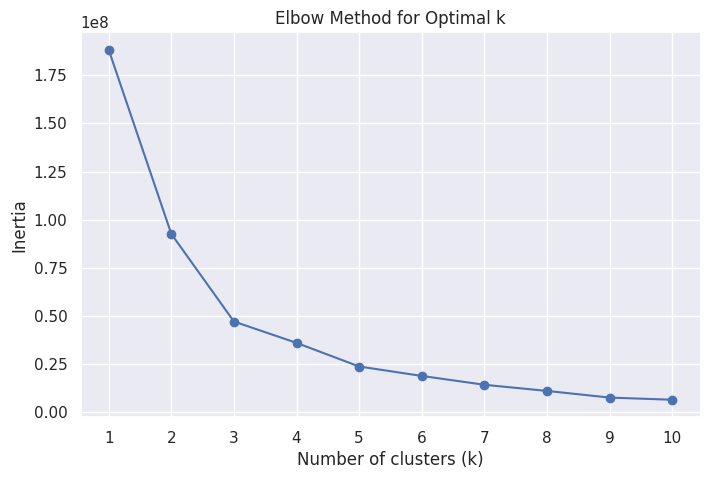

In [13]:
# Compute inertia (within-cluster distance) for k = 1–10
inertias = []
K_range = range(1, 11)

station_coords = df.groupby("Standort_ID")[["Koord_Ost", "Koord_Nord"]].mean()

for k in K_range:
    km = KMeans(n_clusters=k, random_state=42, n_init="auto")
    km.fit(station_coords)
    inertias.append(km.inertia_)

# Plot elbow curve
plt.figure(figsize=(8,5))
plt.plot(K_range, inertias, marker="o")
plt.xlabel("Number of clusters (k)")
plt.ylabel("Inertia")
plt.title("Elbow Method for Optimal k")
plt.xticks(K_range)
plt.grid(True)
plt.show()


after 3 the drop is smaller, continue working with 3 clusters

In [16]:
# Build a station-level coordinates table
station_coords = df.groupby("Standort_ID")[["Koord_Ost", "Koord_Nord"]].mean()

# Choose number of clusters (you can change 6 to 4, 8, etc.)
n_clusters = 3

kmeans = KMeans(n_clusters=n_clusters, random_state=42, n_init="auto")
kmeans.fit(station_coords)

# Map each station to its spatial cluster
station_cluster = dict(zip(station_coords.index, kmeans.labels_))

df["location_cluster"] = df["Standort_ID"].map(station_cluster)

df[["Standort_ID", "Koord_Ost", "Koord_Nord", "location_cluster"]].head()

# Merge cluster labels back to the station_coords table
station_coords_plot = station_coords.copy()
station_coords_plot["location_cluster"] = kmeans.labels_

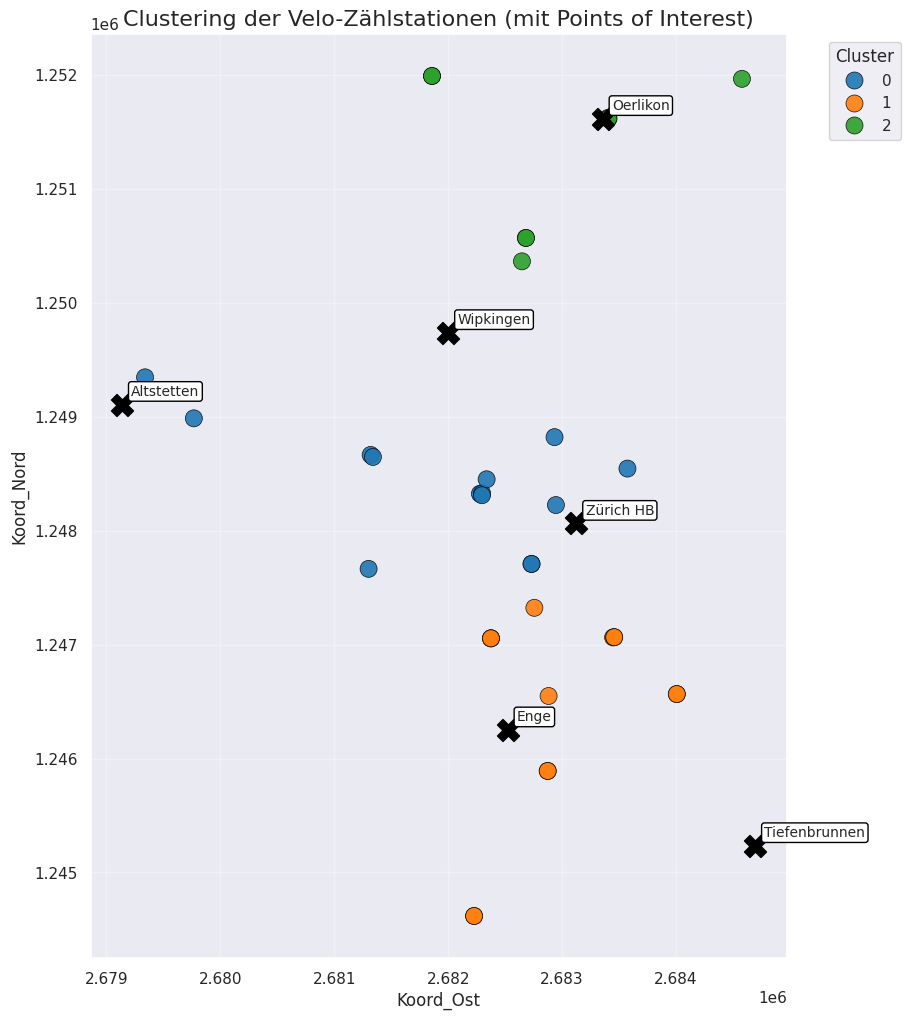

In [20]:
# Clean & Professional Zurich Cluster Visualization

# Build station-level summary table
station_stats = df.groupby("Standort_ID").agg(
    Koord_Ost=("Koord_Ost", "mean"),
    Koord_Nord=("Koord_Nord", "mean"),
    location_cluster=("location_cluster", "first")
)

plt.figure(figsize=(12, 12))

# Scatterplot for clusters
sns.scatterplot(
    data=station_stats,
    x="Koord_Ost",
    y="Koord_Nord",
    hue="location_cluster",
    palette="tab10",
    s=150,        # Fixed point size
    edgecolor="black",
    linewidth=0.5,
    alpha=0.9
)

# --- POIs ---
POIs = {
    "Zürich HB": (2683125, 1248063),
    "Oerlikon": (2683357, 1251616),
    "Tiefenbrunnen": (2684695, 1245234),
    "Enge": (2682523, 1246250),
    "Altstetten": (2679138, 1249107),
    "Wipkingen": (2682001, 1249737)
}

for name, (x, y) in POIs.items():
    plt.scatter(x, y, s=250, marker="X", color="black")
    plt.text(
        x + 80, y + 80, name,
        fontsize=10,
        bbox=dict(facecolor="white", edgecolor="black", boxstyle="round,pad=0.2")
    )

# --- Styling ---
plt.title("Clustering der Velo-Zählstationen (mit Points of Interest)", fontsize=16)
plt.xlabel("Koord_Ost", fontsize=12)
plt.ylabel("Koord_Nord", fontsize=12)

plt.gca().set_aspect("equal", adjustable="box")

# Legende optimieren
plt.legend(
    title="Cluster",
    bbox_to_anchor=(1.05, 1),
    loc="upper left",
    frameon=True
)

plt.grid(alpha=0.3)
plt.show()


# Save CSV

In [35]:
df["Standort_ID"] = df["Standort_ID"].astype('category')


df.to_csv("/content/drive/MyDrive/CAS/VeloCheckZH/data/processed/data_for_model_engineered.csv", index=False)
#df.to_csv("../data/processed/data_for_model_engineered.csv", index=False)
df.head()
df.info()



<class 'pandas.core.frame.DataFrame'>
Index: 23799 entries, 0 to 23798
Data columns (total 19 columns):
 #   Column                   Non-Null Count  Dtype         
---  ------                   --------------  -----         
 0   Standort_ID              23799 non-null  category      
 1   Datum                    23799 non-null  datetime64[ns]
 2   Koord_Ost                23799 non-null  int64         
 3   Koord_Nord               23799 non-null  int64         
 4   Velo                     23799 non-null  float64       
 5   year                     23799 non-null  int64         
 6   day_of_year              23799 non-null  int64         
 7   Niederschlag             23799 non-null  float64       
 8   Temperatur Durchschnitt  23799 non-null  float64       
 9   weekday                  23799 non-null  category      
 10  weekend                  23799 non-null  bool          
 11  is_holiday               23799 non-null  bool          
 12  month                    23799 non-nu